In [39]:
import pandas as pd

from util.sql_switch import get_query_native

count_query = "select count(ds.title), ds.title, ds.created_at \
from delab_moderationrating mr \
    join delab_moderationcandidate2 d on mr.mod_candidate_id = d.id \
    join delab_tweet dt on dt.id = d.tweet_id \
    join delab_simplerequest ds on dt.simple_request_id = ds.id \
where mr.u_moderating_part is not null \
  and mr.u_moderating_part <> '' \
group by \
    ds.title, ds.created_at \
order by count(ds.title) desc"

df_term_counts = get_query_native(count_query)
# print(df_term_counts.head(8))


# squashing similar titles
import functools as ft

list_of_similar_terms = [["Thema", "bleiben"], ["calm", "down"], ["constructive", "criticism"], ["explain"],
                         ["stay", "topic"], ["whataboutism"], ["valid", "point"], ["Perspektive"], ["agree"],
                         ["summary"]]


def title_group_mapper(text):
    group_title = text
    for term_group in list_of_similar_terms:
        for term in term_group:
            if term in text and group_title == text:
                group_title = ft.reduce(lambda x, y: x + "_" + y, term_group)
    return group_title


grouped_titles = df_term_counts["title"].map(title_group_mapper)
df_term_counts["grouped_titles"] = grouped_titles
df_term_counts.drop(["title", "created_at"], axis=1, inplace=True)
df_term_counts = df_term_counts.groupby("grouped_titles").sum()
df_term_counts.sort_values(by=["count"], axis=0, inplace=True, ascending=False)
df_term_counts.head(10)

using postgres


/home/dehne/PycharmProjects/delab/venv/lib/python3.10/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


,count
grouped_titles,
Thema_bleiben,170
"""hear your view""",50
stay_topic,46
explain,45
"""can you elaborate""",42
valid_point,41
"""näher erläutern""",39
constructive_criticism,34
agree,30


# Summary of biggest inter-coder conflicts

- load moderation rating from database or use previous
- show a list of top 10 conflicting ratings

In [40]:
import numpy as np

intercoder_query = "select dt.text, ds.created_at, ds.title, mr.u_moderating_part, mr.u_mod_rating as rating1, mr2.u_mod_rating as rating2, mr.mod_coder_id as coder_id_1, mr2.mod_coder_id as coder_id_2 \
from delab_moderationrating mr \
    join delab_moderationcandidate2 d on mr.mod_candidate_id = d.id \
    join delab_moderationrating mr2 on mr2.mod_candidate_id = d.id \
    join delab_tweet dt on dt.id = d.tweet_id \
    join delab_simplerequest ds on dt.simple_request_id = ds.id \
where mr.u_moderating_part is not null \
  and mr.u_moderating_part <> '' \
  and ds.created_at > '2022-09-01 00:00:00' \
  and mr.mod_coder_id <> mr2.mod_coder_id \
  and mr.u_mod_rating <> mr2.u_mod_rating;"

df_ic = get_query_native(intercoder_query)
df_ic.drop_duplicates("text", inplace=True)
grouped_titles = df_ic["title"].map(title_group_mapper)
df_ic["grouped_titles"] = grouped_titles
df_ic.drop("title", axis=1, inplace=True)


# print(df_ic.head(3))

def calculate_coding_distance(df):
    bigger = df.max(axis=1)
    smaller = df.min(axis=1)
    result = (bigger - smaller).abs()
    return result


df_ic["intercoder_distance"] = calculate_coding_distance(df_ic[["rating1", "rating2"]])
df_ic.sort_values(by="intercoder_distance", inplace=True, ascending=False)

df_ic.head(10)

using postgres


/home/dehne/PycharmProjects/delab/venv/lib/python3.10/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


,text,created_at,u_moderating_part,rating1,rating2,coder_id_1,coder_id_2,grouped_titles,intercoder_distance
0,"@SvenHillenkamp Man könnte im Einzelfall wohl tatsächlich argumentieren, dass der/die vegan lebende Klima-Aktivist/in ohne Kinder faktisch weniger ""verantwortlich"" ist als der fleischessende SUV-Fahrer mit Ölheizung.\n\nAn dieser Stelle interessiert mich Ihre Sichtweise zu einem verwandten Aspekt:",2022-10-07 11:16:24.050504+00:00,An dieser Stelle interessiert mich Ihre Sichtweise zu einem verwandten Aspekt:,2,-2,1,9,Sichtweise,4
100,@tankosulaiman @coolrhinoxx @_Street_General Explain to me ahbeg coz I’m confused,2022-11-15 14:31:03.881262+00:00,Explain to me ahbeg coz I’m confused,2,-2,11,1,explain,4
226,@wrong_speak Totally agree with you. We need to be able to have objective discourse. Just my opinion but a lot of liberals seem to have a hard time with that,2022-11-17 10:00:01.918688+00:00,Totally agree with you,2,-2,11,1,agree,4
227,@wrong_speak Disagreement is to be expected. We’re all different with different viewpoints and ways of thinking and approaching issues. It’s how we bridge those differences that is telling. I appreciate how you approach communicating your POV. So refreshing in this medium.,2022-11-17 10:00:01.918688+00:00,Disagreement is to be expected. \r\nI appreciate how you approach communicating your POV.,2,-2,5,1,agree,4
228,"@ItBegins2012 @erikslater_ @TheSteinLine @KyrieIrving @joetsai1999 He did not apologize, was extremely adamant, emphatic about that, and he was dismissed. Siiimple. He wanted to come back. After he said no to an apology. Coming back is different. Can you understand that distinction?To come back he needs to do more. Makes sense.",2022-11-17 10:10:10.968562+00:00,Can you understand that distinction?,2,-2,11,1,"""can you understand""",4
232,@zestoyy @superkamigb Literally every time i say i dont like it you say it gets better a little after where im at like i didnt like pre grand line and you said wait until you get to the grand line i didnt like the first two arcs and you said wait until skypiea can you understand my frustration,2022-11-17 10:10:10.968562+00:00,can you understand my frustration,2,-2,11,1,"""can you understand""",4
233,"@KriskoDisko @scolegit13 I mean racial slur is always a one way road and the other way around is never any problem, using racial slur or derogatory names for us.\n\nCan you understand why? I’m not sure by I have my theories of why it’s so.",2022-11-17 10:10:10.968562+00:00,Can you understand why?,2,-2,11,1,"""can you understand""",4
234,"@ArchaeoHermes @Graham__Hancock I appreciate your response. Have you read any of his work, other than excerpts that have been cherry picked by other academics? Can you understand how blanket statement of graham not ""understanding science"" could come across as academic elitism?",2022-11-17 10:10:10.968562+00:00,"I appreciate your response. ; Can you understand how blanket statement of graham not ""understanding science"" could come across as academic elitism?",2,-2,11,1,"""can you understand""",4
236,"@TitoMFCruz The physical abilities of track and field athletes evolve. ⭕️\nThe physical abilities of NBA players have evolved.❌\n\nBecause the rules are different and the muscles used are different.\nRather, modern people don't have excellent training for physical ability.\ncan you understand ？ https://t.co/SnqisL5aHG",2022-11-17 10:10:10.968562+00:00,can you understand ？,2,-2,11,1,"""can you understand""",4
237,"@warmburial It’s vague. I read every word. It is a proposal without firm boundaries. Now you might live your life on the fly. Go for it. But as far as law is concerned, specific language is needed or exploitation will occur. Can you understand that?",2022-11-17 10:10:10.968562+00:00,Can you understand that?,2,-2,11,1,"""can you understand""",4


# Summary of inter-coder-reliability over time and per phrases
- load the dataset from the db
- set 2 to 1, and -2 to -1 for simplicity
- compute Krippendorf-Alpha for the ratings
- plot Krippendorf-Alpha over time globally
- plot Krippendorf-Alpha over time per title

In [41]:
import simpledorff

inter_coder_reliability_query = "select ds.created_at, ds.title, mr.u_mod_rating, mr.mod_coder_id \
from delab_moderationrating mr \
    join delab_moderationcandidate2 d on mr.mod_candidate_id = d.id \
    join delab_tweet dt on dt.id = d.tweet_id \
    join delab_simplerequest ds on dt.simple_request_id = ds.id \
where mr.u_moderating_part is not null \
  and mr.u_moderating_part <> '' \
  and mr.u_mod_rating <> 0"

df_rel = get_query_native(inter_coder_reliability_query)
grouped_titles = df_rel["title"].map(title_group_mapper)
df_rel["grouped_titles"] = grouped_titles
df_rel.drop("title", axis=1, inplace=True)

value_mapping = {2: 1, -2: -1}
coder_mapping = {1: 1}
for i in range(2, 100):
    coder_mapping[i] = 2
df_rel.replace({"mod_coder_id": value_mapping}, inplace=True)
df_rel.replace({"mr.mod_coder_id": coder_mapping}, inplace=True)
# create new time_stamp_column that takes a time_stamp every 10 units per topic
df_rel["created_at"] = df_rel["created_at"].map(lambda x: pd.to_datetime(x))
df_rel.sort_values(by="created_at", inplace=True)
df_rel.set_index("created_at", inplace=True)


def compute_incremental_krippendorf_column(df):
    df = df.copy(deep=True)
    date2krippendorf = {}

    # debugging code
    if "valid_point" in list(df.grouped_titles):
        print("testing incremental krippendorf")
    if "Sichtweise" in list(df.grouped_titles):
        print("testing krippendorf 0")

    week_labels_list = []
    for week_index, weekly_labels in df.groupby(pd.Grouper(freq="3D")):
        try:
            week_labels_list.append(weekly_labels)
            week_labels_aggro = pd.concat(week_labels_list)
            s_dorf = simpledorff.calculate_krippendorffs_alpha_for_df(week_labels_aggro, experiment_col='created_at',
                                                                      annotator_col='mod_coder_id',
                                                                      class_col='u_mod_rating')
        except ZeroDivisionError:
            s_dorf = np.NaN

        for date in weekly_labels.index:
            date2krippendorf[date] = s_dorf

    pd.options.mode.chained_assignment = None
    df["krippendorf"] = df.index.map(date2krippendorf)
    return df


# compute the krippendorf for each title_group
krippendorfed_frames = []

for title in set(df_rel.grouped_titles):
    single_title_dataset = df_rel[df_rel["grouped_titles"] == title]
    df_rel_single_with_krippendorf = compute_incremental_krippendorf_column(single_title_dataset)
    krippendorfed_frames.append(df_rel_single_with_krippendorf)

df_rel_with_krippendorf = pd.concat(krippendorfed_frames)
# printing out the codings from the last day and their incremental krippendorf (aggregated over all weeks)
df_rel_with_krippendorf.last("1D")


using postgres


/home/dehne/PycharmProjects/delab/venv/lib/python3.10/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


testing krippendorf 0
testing incremental krippendorf


,u_mod_rating,mod_coder_id,grouped_titles,krippendorf
created_at,,,,
2022-11-24 16:02:47.377066+00:00,2,11,"""would like to understand""",NaN
2022-11-24 16:02:47.377066+00:00,1,11,"""would like to understand""",NaN
2022-11-24 16:02:47.377066+00:00,2,11,"""would like to understand""",NaN
2022-11-24 16:02:47.377066+00:00,2,11,"""would like to understand""",NaN
2022-11-24 16:02:47.377066+00:00,1,11,"""would like to understand""",NaN
...,...,...,...,...
2022-11-14 15:02:00.581644+00:00,2,11,"""weiter erklären""",0.0
2022-11-14 15:02:00.581644+00:00,1,1,"""weiter erklären""",0.0
2022-11-14 15:02:00.581644+00:00,2,11,"""weiter erklären""",0.0


### Summary of best working Terms:
- sorted by the highest krippendorf at the current time aggregating all data
- grouped by the phrases

In [42]:
df_rel_highest_icr = df_rel_with_krippendorf.groupby("grouped_titles").last()
df_rel_highest_icr = df_rel_highest_icr.drop(["u_mod_rating", "mod_coder_id"], axis=1)
df_rel_highest_icr = df_rel_highest_icr[df_rel_highest_icr["krippendorf"] != 0]
df_rel_highest_icr.sort_values(by="krippendorf", inplace=True, ascending=False)


# computed the krippendorf column
# listing the highest icr by grouped_title
df_rel_highest_icr.head(5)

,krippendorf
grouped_titles,
stay_topic,0.379310
valid_point,-0.029412
Thema_bleiben,-0.200000
explain,-0.217391
constructive_criticism,-0.235294


In [43]:
#calculate overall average of krippendorf

inter_coder_reliability_query = "select ds.created_at, ds.title, mr.u_mod_rating, mr.mod_coder_id \
from delab_moderationrating mr \
    join delab_moderationcandidate2 d on mr.mod_candidate_id = d.id \
    join delab_tweet dt on dt.id = d.tweet_id \
    join delab_simplerequest ds on dt.simple_request_id = ds.id \
where mr.u_moderating_part is not null \
  and mr.u_moderating_part <> ''"

df_rel_2 = get_query_native(inter_coder_reliability_query)

s_dorf = simpledorff.calculate_krippendorffs_alpha_for_df(df_rel_2, experiment_col='created_at',
                                                          annotator_col='mod_coder_id',
                                                          class_col='u_mod_rating')
s_dorf

using postgres


/home/dehne/PycharmProjects/delab/venv/lib/python3.10/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


-0.1031280547409581

# Computing Time Sliced Development of Krippendorf

- write procedure to slice the dataframe in time spans of a week
- calculate the krippendorf per title group and week (if possible)
- plot the changes in krippendorf over time

<AxesSubplot:xlabel='created_at'>

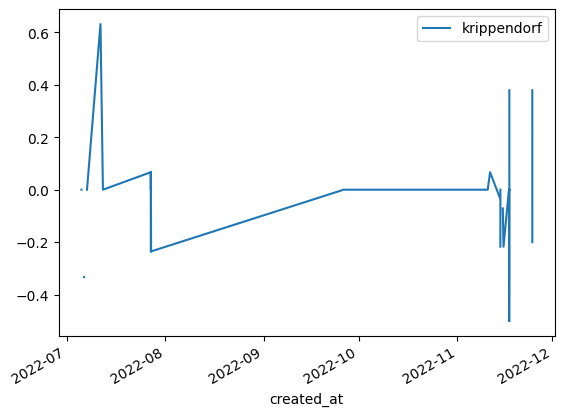

In [44]:
# krippendorf alpha for all terms
df_rel_with_krippendorf.plot.line(y="krippendorf")




Alle 0 für constructive_criticism!>
Alle 0 für explain!>


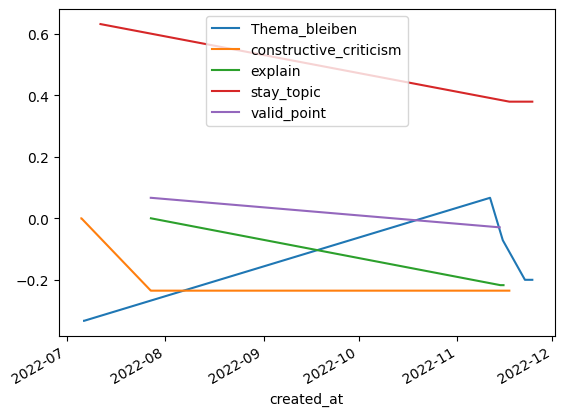

In [45]:
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt

top_5_titles = df_rel_highest_icr.head(5)
df_rel_top_5 = df_rel_with_krippendorf[df_rel_with_krippendorf["grouped_titles"].isin(top_5_titles.index.to_list())]
#df_rel_top_5.reset_index(inplace=True)

fig, ax = plt.subplots()

for key, grp in df_rel_top_5.groupby(['grouped_titles']):
    if grp.empty:
        print('DataFrame is empty for title {}!'.format(key))
    if grp[grp["krippendorf"] > 0].empty:
        print('Alle 0 für {}!>'.format(key))
    ax = grp.plot(ax=ax, kind='line', y='krippendorf', label=key)
#ax.set_xlim([datetime.date(2022, 9, 15), datetime.date(2023, 1, 1)])
plt.legend(loc='best')
plt.show()
